In [5]:
import numpy as np
import builtins
import keras
import tensorflow as tf
from extra_keras_metrics import average_precision_at_k
from IPython.display import SVG
from keras.utils.vis_utils import plot_model
import pydot as pyd
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pyd

import random

In [6]:
data_size = 500
max_transaction_history = 20
max_product_click_history = 20
max_promotion_click_history = 20
input_embedding_size = 16
category_size = 10
numeric_size = 10

data1 = np.random.randint(category_size, size=(data_size, random.randint(1,max_transaction_history)))
data1 = tf.keras.preprocessing.sequence.pad_sequences(data1, max_transaction_history, padding='post')
#data1 = np.array([[1,2], [1,2,4]])

data2 = np.random.randint(category_size, size=(data_size, max_product_click_history-3))
data2 = tf.keras.preprocessing.sequence.pad_sequences(data2, max_product_click_history, padding='post')

data3 = np.random.randint(category_size, size=(data_size, max_promotion_click_history-4))
data3 = tf.keras.preprocessing.sequence.pad_sequences(data3, max_promotion_click_history, padding='post')

inputs = [data1, data2, data3]

single_category_cols = {105:(3,8),106:(5,8),107:(10,8)}   ## such as location : unique_value_size
for k in single_category_cols:
    inputs.append(np.random.randint(single_category_cols[k][0], size=(data_size, 1)))

num1 = np.random.random(size=(data_size, numeric_size))
inputs.append(num1)

labels = np.random.randint(category_size, size=(data_size, 1))
one_hot_labels = keras.utils.to_categorical(labels, num_classes=category_size)

In [109]:
class RecoCNN():
    
    def __init__(self, max_transaction_history = 50, max_product_click_history = 50, max_promotion_click_history = 50,
                 category_size = 100, single_categorical_features = None, numeric_features_size = 10,
                 hidden_layer1_size = 256, hidden_layer2_size = 128, hidden_layer3_size = 64, activation='relu',
                input_embedding_size = 128):
        
        self.max_transaction_history = max_transaction_history
        self.max_product_click_history = max_product_click_history
        self.max_promotion_click_history = max_promotion_click_history
        self.category_size = category_size
        self.hidden_layer1_size = hidden_layer1_size
        self.hidden_layer2_size = hidden_layer2_size
        self.hidden_layer3_size = hidden_layer3_size
        self.single_categorical_features = single_categorical_features
        self.numeric_features_size = numeric_features_size
        self.activation = activation
        self.input_embedding_size = input_embedding_size
        
        self.category_embeddings = tf.keras.layers.Embedding(output_dim=self.input_embedding_size, 
                                                             input_dim = self.category_size, mask_zero=False, name='category_embeddings')
        self.filter_sizes = [3,4,5]
        self.num_filters = 256
        
        self.build()
        
    
    def build(self):
        seq_layer, seq_embed, singles = self.create_input()
        flatten = self.cnn_seq_encode(seq_embed)
        merge_input = self.merge_seq_single(flatten, singles)
        v = tf.keras.layers.Dense(self.hidden_layer1_size, activation = self.activation)(merge_input)
        v = tf.keras.layers.Dense(self.hidden_layer2_size, activation = self.activation)(v)
        v = tf.keras.layers.Dense(self.hidden_layer3_size, activation = self.activation, name='user_embedding')(v)
        output = tf.keras.layers.Dense(self.category_size, activation ='softmax', name='softmax_layer')(v)
        self.model = tf.keras.models.Model(inputs = seq_layer + [s[0] for s in singles], outputs = [output])    
        
    def merge_seq_single(self, flatten, singles):
        cat_ = [flatten]
        cat_ += [s[1] for s in singles]
        return tf.keras.layers.concatenate(cat_, axis=1)
    
    def cnn_seq_encode(self, seq_embed):
        
        cat_embedding = tf.keras.layers.concatenate(seq_embed, axis=1)
        cat_embedding = tf.keras.layers.Reshape((max_transaction_history*3, self.input_embedding_size,1))(cat_embedding)
        conv_0 = tf.keras.layers.Conv2D(self.num_filters, kernel_size=(self.filter_sizes[0], self.input_embedding_size), padding='valid', kernel_initializer='normal', activation='relu')(cat_embedding)
        conv_1 = tf.keras.layers.Conv2D(self.num_filters, kernel_size=(self.filter_sizes[1], self.input_embedding_size), padding='valid', kernel_initializer='normal', activation='relu')(cat_embedding)
        conv_2 = tf.keras.layers.Conv2D(self.num_filters, kernel_size=(self.filter_sizes[2], self.input_embedding_size), padding='valid', kernel_initializer='normal', activation='relu')(cat_embedding)

        maxpool_0 = tf.keras.layers.MaxPool2D(pool_size=(max_transaction_history*3 - self.filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
        maxpool_1 = tf.keras.layers.MaxPool2D(pool_size=(max_transaction_history*3 - self.filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
        maxpool_2 = tf.keras.layers.MaxPool2D(pool_size=(max_transaction_history*3 - self.filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

        concatenated_tensor = tf.keras.layers.concatenate([maxpool_0, maxpool_1, maxpool_2])
        flatten = tf.keras.layers.Flatten()(concatenated_tensor)
        
        return flatten
    
    def create_input(self):
        
        transaction_cols = [x for x in range(self.max_transaction_history)]
        product_click_cols = [x for x in range(self.max_product_click_history)]
        promotion_click_cols = [x for x in range(self.max_promotion_click_history)]
        seq_category_cols = [transaction_cols, product_click_cols, promotion_click_cols]
        
        seqs = []
        for i, grp in enumerate(seq_category_cols):
            seqs.append(self.seq_categorical_input('seq_categorical_' + str(i), len(grp)))

        singles = []
        if self.single_categorical_features:
            for col in self.single_categorical_features:
                singles.append(self.singe_categorical_input(str(col), self.single_categorical_features[col][0],
                                                           self.single_categorical_features[col][1]))

        nums = self.continous_inputs(self.numeric_features_size)

        inp_layer =  [s[0] for s in seqs]
        #inp_layer += [s[0] for s in singles]
        #inp_layer.append(nums[0])
        inp_embed = [s[1] for s in seqs]
        #inp_embed += [s[1] for s in singles]
        #inp_embed.append(nums[1])
               
        return inp_layer, inp_embed, singles
    
    
    def seq_categorical_input(self, name, max_history):
    
        seq = tf.keras.layers.Input(shape=(max_history,), dtype='int32', name=name)
        input_embeddings = self.category_embeddings(seq)

        return seq, input_embeddings   #keras.layers.add([avg_embedding, max_embedding])

    
    def singe_categorical_input(self, name, unique_size, embedding_size):
        single = tf.keras.layers.Input(shape=(1,), dtype='int32', name=name)
        embeddings = tf.keras.layers.Embedding(output_dim = embedding_size, input_dim = unique_size, 
                           input_length=1, name=name + '_embedding')(single)
        embeddings = tf.keras.layers.Flatten(name = 'flatten_' + name)(embeddings)
        return single, embeddings
    
    def continous_inputs(self, size=None, name='numeric'):
        inp = tf.keras.layers.Input(shape=(size,), dtype='float32', name=name)
        return inp, inp

In [110]:
model = RecoCNN(max_transaction_history, max_product_click_history, max_promotion_click_history, category_size,
                numeric_features_size = numeric_size, input_embedding_size = input_embedding_size,
                single_categorical_features = single_category_cols).model

In [111]:
model.compile(loss='sparse_categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

In [112]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_categorical_0 (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
seq_categorical_1 (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
seq_categorical_2 (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
category_embeddings (Embedding) (None, 20, 16)       160         seq_categorical_0[0][0]          
                                                                 seq_categorical_1[0][0]          
          

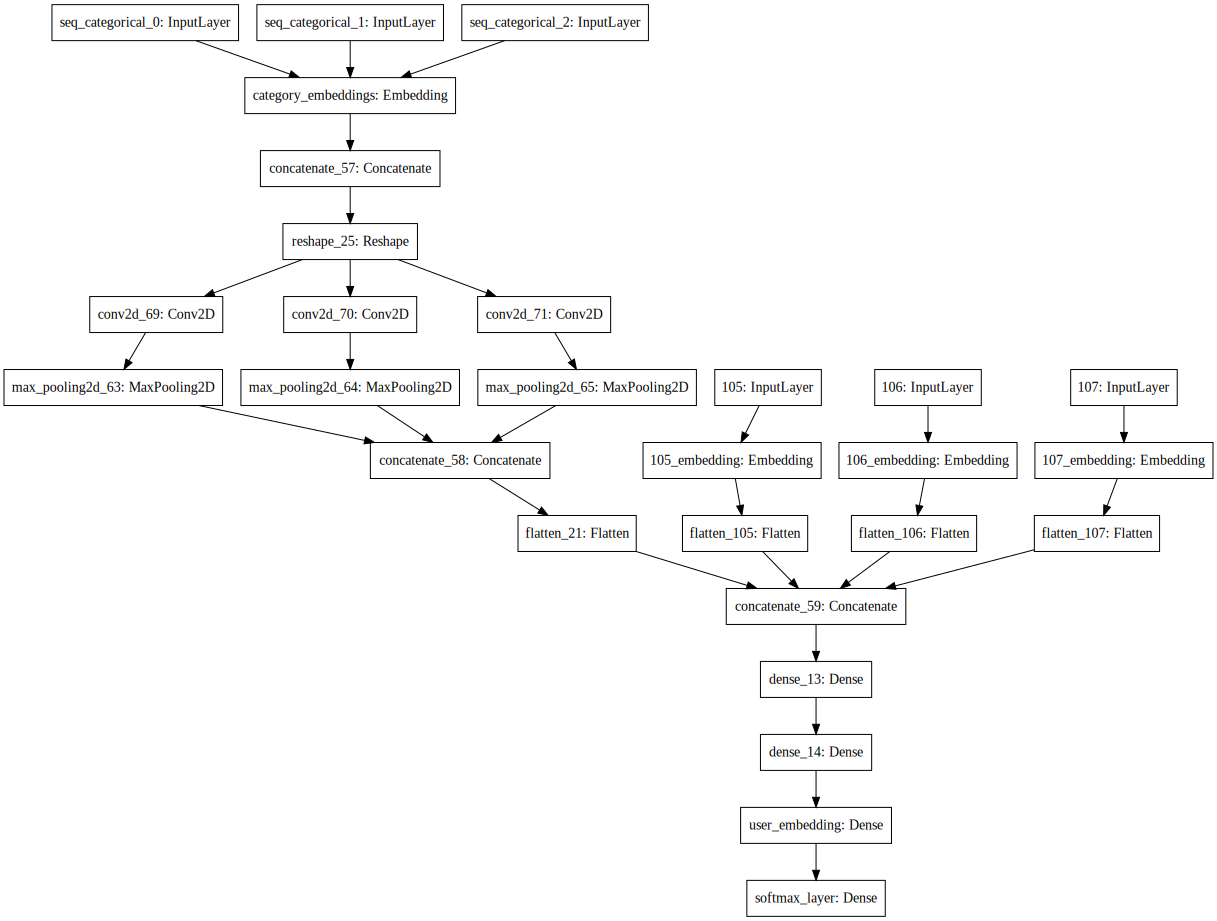

In [113]:
plot_model(model, to_file='../figures/cnn_model.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [114]:
%time model.fit(x=inputs, y=labels, epochs=20, batch_size=32)

Epoch 1/20
500/500 [==============================] - 1s 1ms/sample - loss: 2.3039 - acc: 0.0900
Epoch 2/20
500/500 [==============================] - 0s 430us/sample - loss: 2.2990 - acc: 0.0740
Epoch 3/20
500/500 [==============================] - 0s 418us/sample - loss: 2.2912 - acc: 0.1260
Epoch 4/20
500/500 [==============================] - 0s 404us/sample - loss: 2.2908 - acc: 0.1200
Epoch 5/20
500/500 [==============================] - 0s 395us/sample - loss: 2.2899 - acc: 0.1200
Epoch 6/20
500/500 [==============================] - 0s 387us/sample - loss: 2.2854 - acc: 0.1200
Epoch 7/20
500/500 [==============================] - 0s 401us/sample - loss: 2.2800 - acc: 0.1380
Epoch 8/20
500/500 [==============================] - 0s 403us/sample - loss: 2.2772 - acc: 0.1220
Epoch 9/20
500/500 [==============================] - 0s 394us/sample - loss: 2.2625 - acc: 0.1560
Epoch 10/20
500/500 [==============================] - 0s 403us/sample - loss: 2.2408 - acc: 0.1780
Epoch 11/20